## DFT 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline


/home/pradeep/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def convertToGray(I):
    '''Converts an RGB image to grayscale image.'''
    if(len(I.shape)==2):
        return I
    I = 0.2126 * I[: , : , 0] + 0.7152 * I[: , : , 1] + 0.0722 * I[: , : , 2]
    I = np.round(I)
    I = I.astype(np.int64)
    return I

# Assuming I is image 256 gray levels.
def histogram(I):
    '''Computes the histogram of an image.'''
    hist = np.zeros(256)
    M, N = I.shape
    for i in range(M):
        for j in range(N): hist[I[i][j]] += 1
    
    return hist

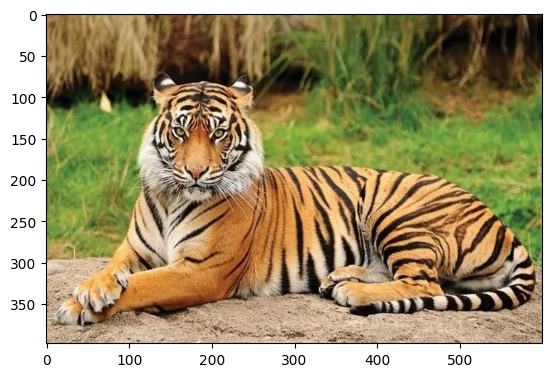

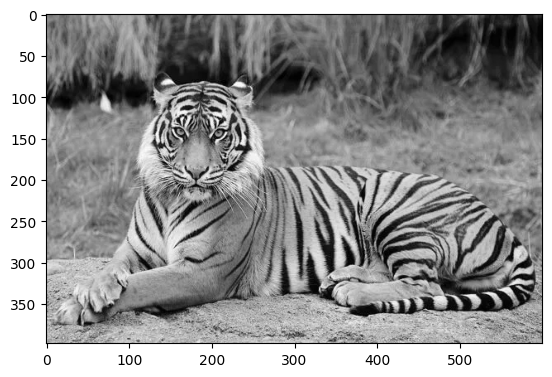

In [3]:
# Load image
img = np.asarray(Image.open('Images/tiger.jpg'))
plt.imshow(img)
plt.show()

gray_img = convertToGray(img)
plt.imshow(gray_img, cmap='gray')
plt.show()

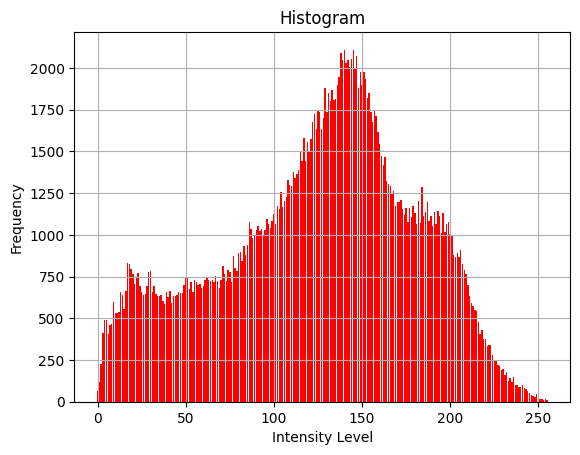

In [4]:
hist = histogram(gray_img)

# plt.hist(gray_img.flatten(), bins=256, color='red', density=True)
plt.bar(range(256), hist, color='red')
plt.xlabel('Intensity Level')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.grid()
plt.show()

In [5]:
# FFT in 1D
def fft1D(signal):
    '''Computes the 1D FFT of a signal. Assumed that the length of the signal is a power of 2.
    Input: signal, a 1D numpy array.
    Returns the 1D FFT of the signal.'''
    N = signal.shape[0]
    if N == 1:
        return signal
    
    fe = fft1D(signal[0::2])
    fo = fft1D(signal[1::2])
    
    w = np.exp(2j * np.pi * np.arange(N/2) / N)
    
    result = np.concatenate([fe + w * fo, fe - w * fo])
        
    return result

def fft2D(I, centered=False):
    '''Computes the 2D FFT of an image. Assumes that the dimensions of the image are a power of 2.
    Input: I, a 2D numpy array.
    Parameter centered: if True, the phase will be centered.
    Returns the magnitude and phase of the 2D FFT.'''
    M, N = I.shape
    
    I = I.copy()
    
    if centered:
        for i in range(M):
            for j in range(N):
                I[i][j] *= (-1)**(i+j)
    
    I_result = np.zeros(I.shape, dtype=np.complex128)
    
    M_padded = 2**np.ceil(np.log2(M)).astype(np.int64)
    N_padded = 2**np.ceil(np.log2(N)).astype(np.int64)
    
    for i in range(M):
        signal = I[i]
        signal = np.concatenate([signal, np.zeros(N_padded - N)])
        signal = fft1D(signal)
        I_result[i, :] = signal[:N]
    
    for j in range(N):
        signal = I_result[: , j]
        signal = np.concatenate([signal, np.zeros(M_padded - M)])
        signal = fft1D(signal)
        I_result[: , j] = signal[:M]
    
    return np.abs(I_result), np.angle(I_result)

def dft_matrix(I, centered=False):
    '''Computes the 2D DFT of an image using matrix multiplication.
    Input: I, a 2D numpy array.
    Parameter centered: if True, the phase will be centered.
    Returns the magnitude and phase of the 2D DFT.'''
    M, N = I.shape
    
    I = I.copy()
        
    if(centered):
        for i in range(M):
            for j in range(N):
                I[i][j] *= (-1)**(i+j)
    
    # declaring matrices of complex exponential
    W_N = np.zeros([N,N], dtype=np.complex64)
    W_M = np.zeros([M,M], dtype=np.complex64)
    
    for u in range(N): 
        for i in range(N):
            W_N[u][i] = u*i
            
    for v in range(M): 
        for j in range(M):
            W_M[v][j] = v*j
    
    W_N = np.exp(-2*np.pi*1j/N) ** W_N
    W_M = np.exp(-2*np.pi*1j/M) ** W_M
    
    dft = np.matmul(np.matmul(W_M, I), W_N)
    
    return np.abs(dft), np.angle(dft)    

def DFT(I, centered=False):
    '''Computes the 2D DFT of an image.
    Input: I, a 2D numpy array.
    Parameter centered: if True, the phase will be centered.
    Returns the magnitude and phase of the 2D DFT.
    If the dimensions of the image are not a power of 2, the DFT is computed using the DFT matrix.
    Otherwise, the FFT algorithm is used.'''
    M, N = I.shape
    if(int(np.log2(M)) == M and int(np.log2(N)) == N):
        return fft2D(I, centered)
    else:
        return dft_matrix(I, centered)

In [6]:
def idft_matrix(mag, phase):
    '''Computes the 2D IDFT of an image.
    Input: mag, the magnitude of the 2D DFT.
           phase, the phase of the 2D DFT.
    Returns the 2D IDFT of the image using the IDFT matrix.'''
    I = mag * np.exp(1j * phase)
    M, N = I.shape
    
    # declaring matrices of complex exponential
    W_N = np.zeros([N,N], dtype=np.complex64)
    W_M = np.zeros([M,M], dtype=np.complex64)
    
    for u in range(N): 
        for i in range(N):
            W_N[u][i] = u*i
            
    for v in range(M): 
        for j in range(M):
            W_M[v][j] = v*j
    
    W_N = np.exp(2*np.pi*1j/N) ** W_N
    W_M = np.exp(2*np.pi*1j/M) ** W_M
    
    idft = np.matmul(np.matmul(W_M, I), W_N)
    idft = idft/(M*N)
    
    return np.real(idft)

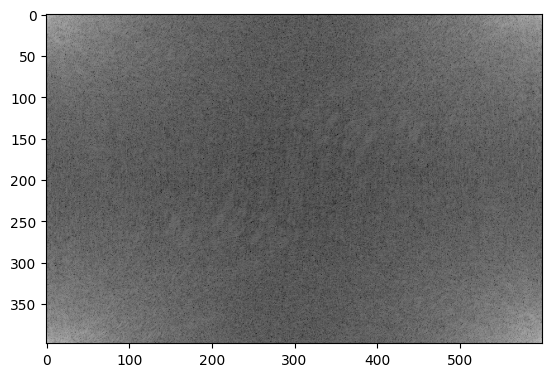

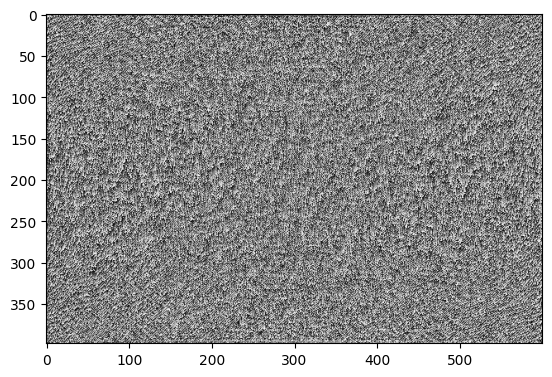

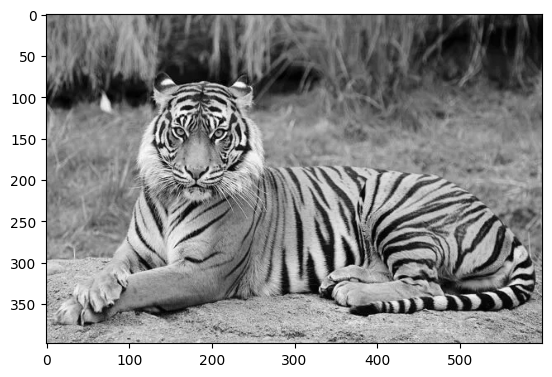

In [7]:
I_dft_mag, I_dft_phase = DFT(gray_img, centered=False)

plt.imshow(np.log(1 + I_dft_mag), cmap='gray')
plt.show()

plt.imshow(I_dft_phase, cmap='gray')
plt.show()

plt.imshow(idft_matrix(I_dft_mag, I_dft_phase), cmap='gray')
plt.show()